In [ ]:
# data package install
# install.packages(c('e1071', 'tree', 'randomForest', 'nnet', 'kernlab'))

In [20]:
library(e1071)        # https://www.rdocumentation.org/packages/e1071/versions/1.7-2
library(tree)         # https://www.rdocumentation.org/pack/tree/versions/1.0-40
library(randomForest) # https://www.rdocumentation.org/packages/randomForest/versions/4.6-14
library(nnet)         # https://www.rdocumentation.org/packages/nnet/versions/7.3-12
library(kernlab)      # https://www.rdocumentation.org/packages/kernlab/versions/0.9-27

# 예측 된 값이 얼마나 잘 적합 했는지 ROC Curve 를 그리고 그 면적의 Area Under the Curve 를 구해서 잘 적합 되는지 본다.
library('ROCR')           # https://www.rdocumentation.org/packages/ROCR/versions/1.0-7 

In [21]:
data(spam)
n <- nrow(spam)       # int 4601 obws
p <- ncol(spam)       # int 58 variables

x <- scale(spam[,-p])     # Scaling and Centering of Matrix-like Objects
                          # Large matrix : 4601 * 57 = 262,257
y <- as.factor(spam[,p])  # "type" : spam, nonsapm

set.seed(1)           # seed 를 1로 고정.
index <- sample(n)    # 4601 의 데이터를 shuffle

n.tr <- 500                     # n.tr : 500 으로 조정

# train, test                   # x index
x.tr <- x[index[ (1:n.tr)], ]   # (1:n.tr) : 1 ~ 500
x.ts <- x[index[-(1:n.tr)], ]   # -(1:n.tr) : -1 ~ -500 # int 배열 x 에서[1 ~ 500] 데이터를 뺀 데이터.

# train, test                   # y index
y.tr <- y[index[ (1:n.tr)]]     # (1:n.tr) : 1 ~ 500
y.ts <- y[index[-(1:n.tr)]]     # -(1:n.tr) : -1 ~ -500 # int 배열 x 에서[1 ~ 500] 데이터를 뺀 데이터.

tr <- data.frame(x.tr, y.tr)    # train 데이터는 data frame 으로 type casting
ts <- data.frame(x.ts, y.ts)    # test 데이터는 data frame 으로 type casting
names(tr) <- names(spam)        # spam 에 있는 header 변수 이름을 train 의 해더로 교체.
                                # 마지막 변수 "y.tr" -> "type" 으로 변경

In [22]:
# Naieve Bayes

# https://www.rdocumentation.org/packages/naivebayes/versions/0.9.6
# apriori 알고리즘 , 참고 url
# https://en.wikipedia.org/wiki/Apriori_algorithm
# https://www.r-bloggers.com/implementing-apriori-algorithm-in-r/
nb <- naiveBayes(type ~ ., data = tr) # type 을 반응 변수로 두고, 모두를 설명 변수로 시작.

nb.y.ts <- predict(nb, ts[,-p])       # ts 의 58 번째 열 y.ts 삭제.
                                      # naems(tr) 로 train set 만 y.tr > type 로 바꿈. ts 는 바꾸지 않음.
                                      # 하기 내용으로 예측된 nb.y.ts 와 실제 맞는 ts[,p] = ts[p]$y.ts 를 비교 한다.

# https://www.rdocumentation.org/packages/ROCR/versions/1.0-7/topics/prediction
pred_naieve <- prediction(as.numeric(nb.y.ts), as.numeric(ts[p]$y.ts))
# https://www.rdocumentation.org/packages/ROCR/versions/1.0-1/topics/performance
# Naieve Bayes 방법으로 활용된 prediction 값으로 auc 값을 확인한다.
result_naieve <- performance(pred_naieve, "auc")@y.values[[1]]
result_naieve

[1] 0.7233339

In [17]:
# Logistic Regression

# https://www.rdocumentation.org/packages/stats/versions/3.6.0/topics/glm
# binomial 로 주는 것이 logistic regression 이다.
# multinomial 로는 다른 패키지를 사용 해야 한다.
logit <- glm(type ~ ., data = tr, family="binomial")
logit.prob <- predict(logit, ts[,-p], type = "response")    # training 된 logit 모델을 ts 의 58 번째 열 y.ts 삭제 후 predict 시작.
logit.y.ts <- ifelse(logit.prob > 0.5, "spam", "nonspam")   # 테스트한 데이터를 기준으로 0.5 기준으로 spam , nospam 으로 나눈다.

# named vector 를 기존의 값(ts[p]$y.ts) 과 비교하기 위해서 factor 로 형 변환을 한다. 이것은 기억하자.
factor_logic <- as.factor(logit.y.ts)
# 하기 내용으로 예측된 factor_logic 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_logit <- prediction(as.numeric(factor_logic), as.numeric(ts[p]$y.ts)) 

# pred_logit 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_logit <- performance(pred_logit, "auc")@y.values[[1]]
result_logit

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] 0.8816199

In [18]:
# Classification Tree
# https://www.rdocumentation.org/packages/tree/versions/1.0-40
# type 을 반응 변수로 두고, 남은 전체를 설명변수로 tree 모델로 fit 시킨다.
tree.sg <- tree(type ~ ., data = tr)
# fit 된 모델의 cross-validation 을 적용한다.
tree.cv <- cv.tree(tree.sg)
# pruning 기법으로 tree 의 가지를 쳐서 제한을 둔다.
# cross-validation 의 deviance 의 값으로 가장 낮은 값의 index 를 선택하여, 거기 까지만 pruning 한다.
# https://www.rdocumentation.org/packages/tree/versions/1.0-40/topics/prune.tree
tree.prune <- prune.tree(tree.sg, best = tree.cv$size[which.min(tree.cv$dev)])
# pruning 한 모델을 가지고 test set 을 넣어 예측한다.
tree.pred <- predict(tree.prune, newdata = ts)
# 예측한 nonspam, spam 두 값으로 비교하여 각 행의 값을 고른다.
tree.sg.y.ts <- ifelse(tree.pred[,1] > tree.pred[,2], "nonspam", "spam")

# named vector 를 기존의 값(ts[p]$y.ts) 과 비교하기 위해서 factor 로 형 변환을 한다. 이것은 기억하자.
factor_tree <- as.factor(tree.sg.y.ts)
# 하기 내용으로 예측된 factor_tree 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_tree <- prediction(as.numeric(factor_tree), as.numeric(ts[p]$y.ts))

# pred_tree 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_tree <- performance(pred_tree, "auc")@y.values[[1]]
result_tree

[1] 0.8738135

In [34]:
# RandomForest
# https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest
# type 을 반응 변수로 두고, 남은 전체를 설명변수로 randomForest 모델로 fit 시킨다.
ranf <- randomForest(type ~ ., data = tr)
# fitting 된 모델을 가지고 test set 을 넣어 예측한다.
ranf.y.ts <- predict(ranf, newdata = ts)

# 하기 내용으로 예측된 ranf.y.ts 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_rf <- prediction(as.numeric(ranf.y.ts), as.numeric(ts[p]$y.ts))
# pred_tree 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_rf <- performance(pred_rf, "auc")@y.values[[1]]
result_rf

[1] 0.9252586

In [35]:
# Gaussian Kernel SVM
C.grid <- (2)^(-5:10) # SVM 은 C가 조율 모수의 역할을 한다.
# https://www.rdocumentation.org/packages/e1071/versions/1.7-2/topics/tune
# tune.svm 으로 kernel 의 default 설정은 "radial" 이다. RBF kernel = Gaussian kernel.
# 정한 gamma, cost 를 가지고 svm tuning 을 시작한다.
tune.obj <- tune.svm(type ~ ., data = tr, gamma = 1/p, cost = C.grid) 

# 가장 좋은 조율 모수 C 정하고
best.C <- tune.obj$best.model$cost 
# type 을 반응 변수로 두고, 남은 전체를 설명 변수로 svm 모델로 fit 시킨다.
svm.gs <- svm(type ~., gamma = 1/p, cost = best.C, data = tr) 
# fitting 된 모델을 가지고 test set 을 넣어 예측한다.
svm.gs.y.ts <- predict(svm.gs, ts)

# 하기 내용으로 예측된 svm.gs.y.ts 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_svm_gs <- prediction(as.numeric(svm.gs.y.ts), as.numeric(ts[p]$y.ts))
# pred_svm_gs 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_svm_gs <- performance(pred_svm_gs, "auc")@y.values[[1]]
result_svm_gs

[1] 0.8934138

In [36]:
# Linear Kernel SVM
C.grid <- (2)^(-5:10) # SVM 은 C가 조율 모수의 역할을 한다.
# https://www.rdocumentation.org/packages/e1071/versions/1.7-1/topics/svm 의 kernel 체크.
# tune.svm 으로 kernel 옵션을 'linear' 로 변경 하고, 정한 cost 를 가지고 svm tuning 을 시작한다.
tune.obj <- tune.svm(type ~ ., data = tr, kernel = "linear", cost = C.grid)

# 가장 좋은 조율 모수 C 정하고
best.C <- tune.obj$best.model$cost
# type 을 반응 변수로 두고, 남은 전체를 설명 변수로 svm 모델로 fit 시킨다.
svm.ln <- svm(type ~ ., data = tr, kernel = "linear", cost = best.C)
# fitting 된 모델을 가지고 test set 을 넣어 예측한다.
svm.ln.y.ts <- predict(svm.ln, ts) 

# 하기 내용으로 예측된 svm.ln.y.ts 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_svm_ln <- prediction(as.numeric(svm.ln.y.ts), as.numeric(ts[p]$y.ts))
# pred_svm_ln 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_svm_ln <- performance(pred_svm_ln, "auc")@y.values[[1]]
result_svm_ln

[1] 0.902973

In [19]:
# neural network
# https://www.rdocumentation.org/packages/nnet/versions/7.3-12/topics/nnet
# maxit - maximum number of iterations. Default 100.
# size - number of units in the hidden layer. Can be zero if there are skip-layer units.
# type 을 반응변수로, 나머지를 설명변수로 두고, hidden layer 를 5개 두고 iteration 을 500 준다.
nrnet <- nnet(type ~., data = tr, size = 5, maxit = 500)
# type 은 class 로 범주형의 타입으로 두고 predict 을 한다.
nrnet.y.ts <- predict(nrnet, ts[,-p], type = "class") 

# char array 를 기존의 값(ts[p]$y.ts) 과 비교하기 위해서 factor 로 형 변환을 한다. 이것은 기억하자.
factor_nrnet <- as.factor(nrnet.y.ts)

# 하기 내용으로 예측된 factor_nrnet 와 실제 맞는 ts[p]$y.ts 를 비교 한다.
pred_nrnet <- prediction(as.numeric(factor_nrnet), as.numeric(ts[p]$y.ts))
# pred_svm_ln 의 AUC 를 보고 모델의 적합성과 얼마나 좋은지 판단 한다.
result_nrnet <- performance(pred_nrnet, "auc")@y.values[[1]]
result_nrnet

# weights:  296
initial  value 337.276842 
iter  10 value 43.404071
iter  20 value 18.774851
iter  30 value 6.551044
iter  40 value 2.677034
iter  50 value 1.943315
iter  60 value 1.927098
iter  70 value 0.572447
iter  80 value 0.048699
iter  90 value 0.040685
iter 100 value 0.026658
iter 110 value 0.016686
iter 120 value 0.009049
iter 130 value 0.004496
iter 140 value 0.002300
iter 150 value 0.001154
iter 160 value 0.000818
iter 170 value 0.000481
iter 180 value 0.000340
iter 190 value 0.000199
iter 200 value 0.000151
final  value 0.000097 
converged
 chr [1:4101] "nonspam" "nonspam" "nonspam" "nonspam" "nonspam" "nonspam" ...


[1] 0.9034861

In [38]:
# 각 모델 방법의 result 종류를 가지고 data frame 을 만든다.
data.frame(method=c('Naieve Bayes','Logistic','Tree','RandomForest','Gaussian SVM', 'Linear SVM', 'Neural Network'),
           auc=c(result_naieve,
                 result_logit,
                 result_tree,
                 result_rf,
                 result_svm_gs,
                 result_svm_ln,
                 result_nrnet
                 ))
# RandomForest 가 제일 높다.

method,auc
Naieve Bayes,0.7233339
Logistic,0.8816199
Tree,0.8738135
RandomForest,0.9252586
Gaussian SVM,0.8934138
Linear SVM,0.9029730
Neural Network,0.8949491


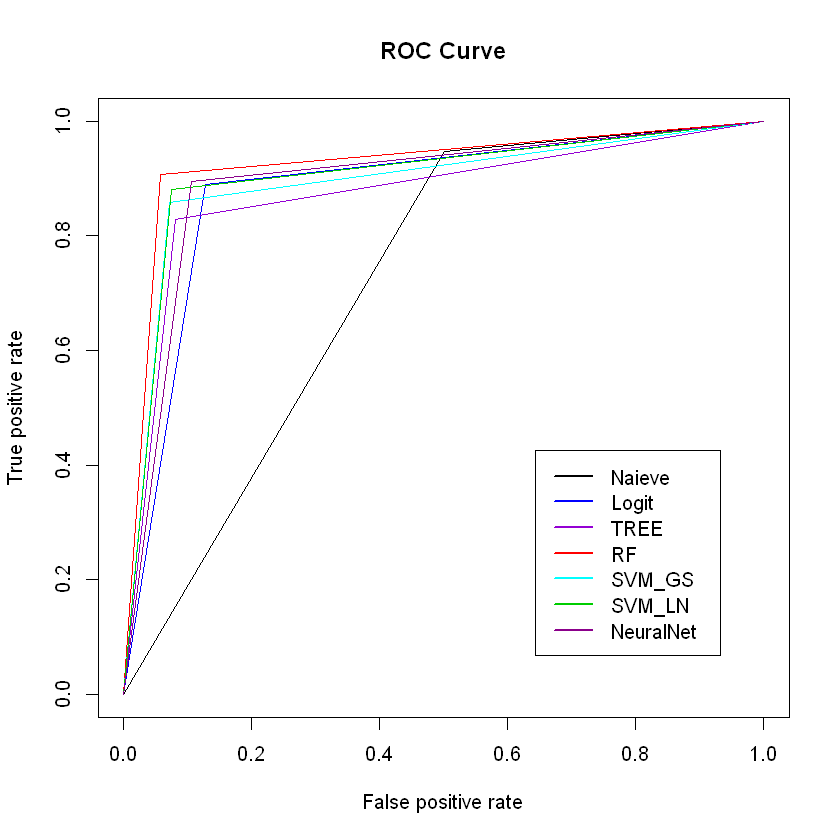

In [40]:
# 각 모델 의 ROC Curve 를 그래프화 시켜서 Visualization 한다.
# https://www.rdocumentation.org/packages/mlr/versions/2.14.0/topics/performance
# [y-axis] measure : true positive rate, [x-axis] x.measure : false positive rate
perf_naieve <- performance(pred_naieve, measure='tpr',x.measure='fpr')
perf_logit <- performance(pred_logit, measure='tpr',x.measure='fpr')
perf_tree <- performance(pred_tree, measure='tpr',x.measure='fpr')
perf_rf <- performance(pred_rf, measure='tpr',x.measure='fpr')
perf_svm_gs <- performance(pred_svm_gs, measure='tpr',x.measure='fpr')
perf_svm_ln <- performance(pred_svm_ln, measure='tpr',x.measure='fpr')
perf_nrnet <- performance(pred_nrnet, measure='tpr',x.measure='fpr')

# 색 별로 ROC Curve 를 그린다.
# https://www.rdocumentation.org/packages/graphics/versions/3.6.0/topics/plot
plot(perf_naieve, col='black', main="ROC Curve")
plot(perf_logit, add=TRUE, col='blue')
plot(perf_tree, add=TRUE, col='darkviolet')
plot(perf_rf, add=TRUE, col='red')
plot(perf_svm_gs, add=TRUE, col='cyan')
plot(perf_svm_ln, add=TRUE, col='green3')
plot(perf_nrnet, add=TRUE, col='magenta4')

# https://www.rdocumentation.org/packages/graphics/versions/3.6.0/topics/legend
# legend 사각형을 bottom 의 오른쪽에 설명을 적는다.
legend('bottomright', inset=.1,
       legend=c("Naieve", "Logit", "TREE", "RF", "SVM_GS", "SVM_LN", "NeuralNet"),
       col=c('black', 'blue', 'darkviolet', 'red', 'cyan', 'green3', 'magenta4'), lty=1, lwd=2)

In [ ]:
# 결론. Random Forest 가 수치가 제일 좋다.